In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [190]:
import os
import matplotlib.pyplot as plt
import json
import pandas as pd
%matplotlib notebook
from pygeotools.lib import iolib, timelib, malib, geolib
from imview.lib import pltlib
import numpy as np
import glob
import multiprocessing as mp

In [300]:
#WV/GE
source = 'ASTER'
round2 = True

if source == 'WV':
    topdir = '/nobackupp8/deshean/hma/dem_coreg'
    globstr = '*track/2*align/*align_stats.json'
    if round2:
        globstr = '*track/2*align/2*align/*align_stats.json'
    bad_globstr = '*track/%s/2*align/*align_stats.json'
elif source =='ASTER':
    topdir = '/nobackupp8/deshean/hma/aster/dsm'
    globstr = '2*/AST*align/*align_stats.json'
    bad_globstr = '%s/AST*align/*align_stats.json'
    if round2:
        globstr = '2*/AST*align/AST*align/*align_stats.json'
    
#Directory for bad align files
baddir = os.path.join(topdir, 'dem_align_bad')
if round2:
    baddir += '_round2'
if not os.path.exists(baddir): os.makedirs(baddir) 
    
prefix = os.path.join(topdir, 'dem_align_%s' % source)
if round2:
    prefix += '_round2'

json_fn_list = glob.glob(os.path.join(topdir, globstr))
if not round2:
    json_fn_list.extend(glob.glob(os.path.join(topdir, bad_globstr % os.path.split(baddir)[-1])))

In [279]:
len(json_fn_list)

27697

See nyc-taxi example from dask pd website, use dask to load all *json into df, rather than mp.Pool

In [280]:
#Function to parse json
def parse_json(json_fn):
    with open(json_fn, 'r') as f:
        d = json.load(f)
        #dt = timelib.fn_getdatetime(os.path.split(d['src_fn'])[-1][0:12])
        dt = timelib.fn_getdatetime(os.path.split(d['src_fn'])[-1])
        out = [dt, d['src_fn'], d['align_fn'], \
               d['shift']['dx'], d['shift']['dy'], d['shift']['dz'], d['shift']['dm'], \
               d['center_coord']['x'], d['center_coord']['y'], \
               d['before_filt']['med'], d['before_filt']['mad'], \
               d['before_filt']['p16'], d['before_filt']['p84'], d['before_filt']['spread'], \
               d['after_filt']['med'], d['after_filt']['mad'], \
               d['after_filt']['p16'], d['after_filt']['p84'], d['after_filt']['spread']]
        return out

#Parallel read
pool = mp.Pool()
#out = [pool.apply(parse_json, args=(json_fn,)) for json_fn in json_fn_list]
out = pool.map(parse_json, json_fn_list)

#out = []
#for i,json_fn in enumerate(json_fn_list):
#    out.append(parse_json(json_fn))

#Can read directly in pandas, but need to reformat
#df = pd.read_json(json_fn, orient='index')

In [281]:
#outa = np.array(out)
columns=['dt','src_fn', 'align_fn', 'dx', 'dy', 'dz', 'dm', 'cx', 'cy', \
         'med_before', 'mad_before', 'p16_before', 'p84_before', 'spread_before', \
         'med_after', 'mad_after', 'p16_after', 'p84_after', 'spread_after']
df = pd.DataFrame(out, columns=columns)
df = df.sort_values(by='dt')

#df = pd.DataFrame(outa, index=outa[:,0], columns=['dt','src_fn','med_before', 'p16_before', 'p84_before', 'med_after', 'p16_after', 'p84_after'])
#df = df.sort_index()

In [282]:
df.columns

Index(['dt', 'src_fn', 'align_fn', 'dx', 'dy', 'dz', 'dm', 'cx', 'cy',
       'med_before', 'mad_before', 'p16_before', 'p84_before', 'spread_before',
       'med_after', 'mad_after', 'p16_after', 'p84_after', 'spread_after'],
      dtype='object')

In [283]:
df.mean(), df.median(), df.std()

(dx               9.883022e-02
 dy               5.291717e-02
 dz               1.160812e-01
 dm               2.024863e+00
 cx               4.987602e+05
 cy               3.839383e+06
 med_before      -1.131106e-01
 mad_before       5.930732e+00
 p16_before      -6.141191e+00
 p84_before       6.122064e+00
 spread_before    6.131627e+00
 med_after        8.417337e-06
 mad_after        5.911875e+00
 p16_after       -6.004393e+00
 p84_after        6.214303e+00
 spread_after     6.109348e+00
 dtype: float64, dx               6.788557e-02
 dy              -1.940608e-02
 dz               8.691406e-02
 dm               1.629776e+00
 cx               4.976958e+05
 cy               3.825664e+06
 med_before      -8.593750e-02
 mad_before       5.789958e+00
 p16_before      -5.940430e+00
 p84_before       5.912598e+00
 spread_before    5.976562e+00
 med_after        0.000000e+00
 mad_after        5.772584e+00
 p16_after       -5.856973e+00
 p84_after        6.015137e+00
 spread_after     5.955

<IPython.core.display.Javascript object>


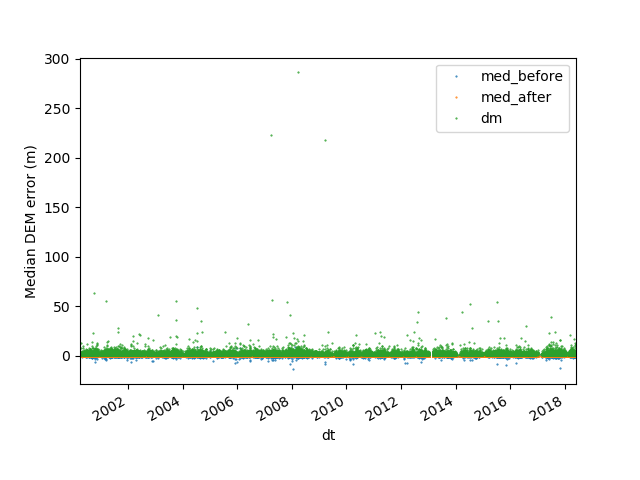

(730208.0208333334, 736845.0208333334)

In [284]:
med_ax = df.plot('dt', ['med_before', 'med_after', 'dm'], ls='none', marker='.', ms=1)
med_ax.set_ylabel('Median DEM error (m)')
med_ax.set_xlim(df['dt'].min(), df['dt'].max())
#med_ax.set_ylim(-100,100)

In [285]:
C = 3.0
def outlier_filter(df, col=None, C=3.0, perc=None, absdiff=None):
    df_mean = df[col].mean()
    #df_mean = df[col].median()
    if absdiff is not None:
        minval = df_mean - absdiff
        maxval = df_mean + absdiff
    elif perc is not None:
        minval, maxval = malib.calcperc(df[col], perc=perc)
    else:
        df_std = df[col].std()
        #df_std = malib.mad(df[col])
        minval = df_mean - C * df_std
        maxval = df_mean + C * df_std
    idx = (df[col] < minval) | (df[col] > maxval)
    print("Removing outliers: %s, (%0.2f to %0.2f), %i" % (col,minval,maxval,idx.sum()))
    #return df[~idx]
    return idx

In [286]:
dm_idx = False
med_after_idx = False
spread_idx = False 
p16_idx = False 
p84_idx = False
med_idx = False 
nmad_idx = False

if source == 'WV':
    #WV/GE
    print(source, 'round1')
    max_dm = 20
    ylim=(-20, 20)
    spread_idx = outlier_filter(df, col='spread_after', perc=(0.0, 99.9))
    p16_idx = outlier_filter(df, col='p16_after', perc=(2, 100.0))
    p84_idx = outlier_filter(df, col='p84_after', perc=(0.0, 98))
elif source == 'ASTER':
    #ASTER
    ylim=(-60, 60)
    max_dm = 60
    if round2:
        print(source, 'round2')
        spread_idx = outlier_filter(df, col='spread_after', perc=(0.0, 99.95))
        p16_idx = outlier_filter(df, col='p16_after', perc=(0.05, 99.9))
        p84_idx = outlier_filter(df, col='p84_after', perc=(0.01, 99.9))
    else:
        print(source, 'round1')
        spread_idx = outlier_filter(df, col='spread_after')
        p16_idx = outlier_filter(df, col='p16_after', perc=(0.5, 100.0))
        p84_idx = outlier_filter(df, col='p84_after', perc=(0.0, 99.5))
        

med_after_idx = outlier_filter(df, col='med_after', absdiff=1)

#dm_idx = outlier_filter(df, col='dm', absdiff=max_dm)
dm_idx = (df['dm'] > max_dm)
print("Removing outliers, dm thresh (%0.2f m): %i" % (max_dm, dm_idx.sum()))

med_idx = (df['med_after'].abs() > 1.1*df['med_before'].abs())
print("Removing outliers, med increase: %i" % med_idx.sum())

#Check if nmad after is larger than before
nmad_idx = (df['mad_after'] > 1.1*df['mad_before'])
print("Removing outliers, nmad increase: %i" % nmad_idx.sum())

#idx = dm_idx | med_after_idx | spread_idx
idx = dm_idx | med_after_idx | spread_idx | p16_idx | p84_idx | med_idx | nmad_idx
print(idx.sum(), df.shape[0], '%0.2f%%' % (100*idx.sum()/df.shape[0]))

print(df.shape)
df_filt = df[~idx]
print(df_filt.shape)


ASTER round2
Removing outliers: spread_after, (0.71 to 14.49), 14
Removing outliers: p16_after, (-14.21 to -2.46), 42
Removing outliers: p84_after, (0.90 to 14.63), 31
Removing outliers: med_after, (-1.00 to 1.00), 0
Removing outliers, dm thresh (60.00 m): 4
Removing outliers, med increase: 10
Removing outliers, nmad incraese: 3
73 27697 0.26%
(27697, 19)
(27624, 19)


In [287]:
#Hack, as the default pandas dt format won't work with the vectorized np_dt2decyear
#dt = timelib.dt2o(df['dt'])
#dt = outa[:,0]
#dt = timelib.np_dt2decyear(df['dt'])
dt = timelib.np_dt2decyear(timelib.o2dt(timelib.dt2o(df['dt'])))
dt

array([2000.24049408, 2000.24049408, 2000.24049408, ..., 2018.41090183,
       2018.41090183, 2018.41090183])

In [293]:
#C = 3.5
#ylim = (C * df['p16_after'].mean(), C * df['p84_after'].mean())
#ylim = (-20, 20)
#idx = (df['p16_after'] < ylim[0]) | (df['p84_after'] > ylim[1]) 
#print(ylim)
ylim=(-20, 20)

<IPython.core.display.Javascript object>


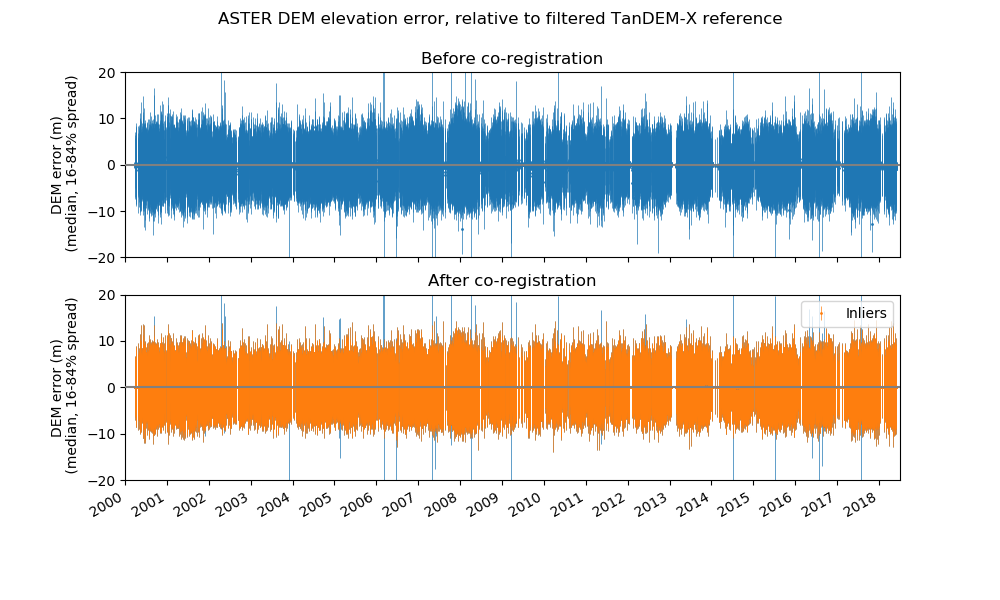

In [294]:
#Should isolate alongtrack and crosstrack
#Potentially plot different colors for different sensors

f, axa = plt.subplots(2,1, sharex=True, sharey=True, figsize=(10,6))
f.suptitle("%s DEM elevation error, relative to filtered TanDEM-X reference" % source)
axa[0].set_title("Before co-registration")
axa[1].set_title("After co-registration")
#ax.plot(df['dt'], df['med_before'], ls='none', marker='o')
errprop={'ls':'none', 'alpha':1.0, 'elinewidth':0.5, 'marker':'.', 'ms':2}
yerr=np.array([df['med_before'] - df['p16_before'], df['p84_before'] - df['med_before']])
axa[0].errorbar(dt, df['med_before'], yerr=yerr, **errprop)
#yerr=np.array([df_filt['med_before'] - df_filt['p16_before'], df_filt['p84_before'] - df_filt['med_before']])
#axa[0].errorbar(dt[~idx], df_filt['med_before'], marker='', yerr=yerr, **errprop)
yerr=np.array([df['med_after'] - df['p16_after'], df['p84_after'] - df['med_after']])
axa[1].errorbar(dt, df['med_after'], yerr=yerr, label=None, **errprop)
yerr=np.array([df_filt['med_after'] - df_filt['p16_after'], df_filt['p84_after'] - df_filt['med_after']])
axa[1].errorbar(dt[~idx], df_filt['med_after'], label='Inliers', yerr=yerr, **errprop)
axa[0].set_ylim(*ylim)
#axa[0].set_xlim(dt.min(), dt.max())
axa[0].set_xlim(2000, 2018.5)
start, end = axa[0].get_xlim()
axa[1].legend()
for ax in axa:
    ax.set_ylabel('DEM error (m)\n (median, 16-84% spread)')
    ax.axhline(0, c='0.5', zorder=99)
    ax.xaxis.set_ticks(np.arange(start, end, 1.0))
    #ax.grid()

"""
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
yearsFmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
"""
f.autofmt_xdate()

In [291]:
print(df_filt.mean())
print(df_filt.std())
print(df_filt.median())

dx               9.994405e-02
dy               8.356738e-02
dz               1.146915e-01
dm               1.990804e+00
cx               4.987072e+05
cy               3.838151e+06
med_before      -1.129487e-01
mad_before       5.925117e+00
p16_before      -6.125273e+00
p84_before       6.110495e+00
spread_before    6.117884e+00
med_after        7.349194e-06
mad_after        5.905010e+00
p16_after       -5.989161e+00
p84_after        6.200638e+00
spread_after     6.094900e+00
dtype: float64
dx                    1.764924
dy                    2.032000
dz                    0.515212
dm                    1.891060
cx               159820.785759
cy               452840.024396
med_before            0.505103
mad_before            1.470411
p16_before            1.635944
p84_before            1.712424
spread_before         1.525219
med_after             0.001868
mad_after             1.459060
p16_after             1.474374
p84_after             1.646181
spread_after          1.512664
dtype: fl

In [292]:
df[idx]

,dt,src_fn,align_fn,dx,dy,dz,dm,cx,cy,med_before,mad_before,p16_before,p84_before,spread_before,med_after,mad_after,p16_after,p84_after,spread_after
16952,2000-09-07 00:30:00,2000/AST_20000907_00309072000045514_DEM_cr_dem...,2000/AST_20000907_00309072000045514_DEM_cr_dem...,-3.440281,12.994490,-2.018555,13.592898,302116.156071,3.389521e+06,1.663086,8.385956,-5.250000,16.634453,10.942227,0.000000,8.569833,-7.083496,15.304199,11.193848
17136,2000-09-29 00:30:00,2000/AST_20000929_00309292000055212_DEM_cr_dem...,2000/AST_20000929_00309292000055212_DEM_cr_dem...,32.381648,-54.738574,-1.673531,63.621406,619211.447071,4.992718e+06,0.779648,5.315244,-4.429274,6.206462,5.317868,0.000275,5.134330,-5.470205,4.935455,5.202830
1152,2001-12-03 00:31:00,2001/AST_20011203_00312032001055628_DEM_cr_dem...,2001/AST_20011203_00312032001055628_DEM_cr_dem...,2.188681,-2.827734,0.068359,3.576462,648735.081453,4.116295e+06,0.000244,10.593930,-10.588867,10.531494,10.560181,-0.000488,10.455660,-10.470703,10.391602,10.431152
25410,2002-04-20 00:30:00,2002/AST_20020420_00304202002045355_DEM_cr_dem...,2002/AST_20020420_00304202002045355_DEM_cr_dem...,2.400049,-0.801352,0.407715,2.562934,611322.460286,3.444882e+06,-0.363770,10.748126,-9.432129,19.962910,14.697520,-0.000488,10.675010,-8.993652,20.253906,14.623779
25728,2002-05-16 00:30:00,2002/AST_20020516_00305162002052939_DEM_cr_dem...,2002/AST_20020516_00305162002052939_DEM_cr_dem...,3.069658,-3.849152,0.148438,4.925526,434571.100411,4.033560e+06,0.063477,11.972285,-10.038818,18.264023,14.151421,-0.000732,11.774653,-9.869209,18.070137,13.969673
25920,2002-05-22 00:30:00,2002/AST_20020522_00305222002045316_DEM_cr_dem...,2002/AST_20020522_00305222002045316_DEM_cr_dem...,-0.813359,-2.498698,-0.208984,2.636043,264459.719907,3.778260e+06,0.207031,6.862092,-5.990723,15.605469,10.798096,0.000000,6.882362,-6.198242,15.430664,10.814453
26312,2002-10-08 00:31:00,2002/AST_20021008_00310082002061158_DEM_cr_dem...,2002/AST_20021008_00310082002061158_DEM_cr_dem...,0.414002,0.517856,-0.024414,0.663452,748564.481984,4.122920e+06,0.000000,5.929676,-5.951416,6.129639,6.040527,0.000244,5.925333,-5.967041,6.106689,6.036865
11869,2003-08-10 00:30:00,2003/AST_20030810_00308102003055723_DEM_cr_dem...,2003/AST_20030810_00308102003055723_DEM_cr_dem...,-0.714188,1.895148,-0.004395,2.025258,399704.479777,4.320891e+06,0.028809,11.051451,-10.454102,17.541504,13.997803,0.000000,10.941414,-10.357910,17.456299,13.907104
11819,2003-11-30 00:31:00,2003/AST_20031130_00311302003055809_DEM_cr_dem...,2003/AST_20031130_00311302003055809_DEM_cr_dem...,-5.747520,2.067726,2.759888,6.702720,652238.702447,4.702660e+06,-2.606323,11.947852,-26.324463,7.385254,16.854858,-0.000244,11.997803,-23.562178,9.981201,16.771689
14339,2004-04-11 00:30:00,2004/AST_20040411_00304112004061543_DEM_cr_dem...,2004/AST_20040411_00304112004061543_DEM_cr_dem...,1.389687,0.032829,-0.060150,1.391375,560627.861974,4.679833e+06,0.072205,1.779953,-2.025024,2.537292,2.281158,-0.000122,1.780043,-2.099670,2.453430,2.276550


In [301]:
df[idx]['align_fn'].to_csv(prefix+'_bad_fn.txt', index=False)
df[~idx]['align_fn'].to_csv(prefix+'_good_fn.txt', index=False)

In [302]:
baddir

'/nobackupp8/deshean/hma/aster/dsm/dem_align_bad_round2'

In [303]:
import shutil
for i in df[idx]['align_fn']:
    dirname = os.path.split(i)[0]
    print("Moving %s to %s" % (dirname, baddir))
    shutil.move(os.path.split(i)[0], baddir)

Moving 2000/AST_20000907_00309072000045514_DEM_cr_dem_align/AST_20000907_00309072000045514_DEM_cr_TDM1_DEM_90m_hma_DEM_masked_nuth_x+1.16_y-28.60_z+6.33_align_dem_align to /nobackupp8/deshean/hma/aster/dsm/dem_align_bad_round2
Moving 2000/AST_20000929_00309292000055212_DEM_cr_dem_align/AST_20000929_00309292000055212_DEM_cr_TDM1_DEM_90m_hma_DEM_masked_nuth_x-35.93_y+7.82_z-1.55_align_dem_align to /nobackupp8/deshean/hma/aster/dsm/dem_align_bad_round2
Moving 2001/AST_20011203_00312032001055628_DEM_cr_dem_align/AST_20011203_00312032001055628_DEM_cr_TDM1_DEM_90m_hma_DEM_masked_nuth_x-2.11_y+12.83_z+4.87_align_dem_align to /nobackupp8/deshean/hma/aster/dsm/dem_align_bad_round2
Moving 2002/AST_20020420_00304202002045355_DEM_cr_dem_align/AST_20020420_00304202002045355_DEM_cr_TDM1_DEM_90m_hma_DEM_masked_nuth_x+10.06_y-1.85_z-11.91_align_dem_align to /nobackupp8/deshean/hma/aster/dsm/dem_align_bad_round2
Moving 2002/AST_20020516_00305162002052939_DEM_cr_dem_align/AST_20020516_00305162002052939_

In [262]:
def make_plot3d(df, title=None, orthogonal_fig=True, maxdim=None):
    x = df['dx']
    y = df['dy']
    z = df['dz']
    cmean = np.mean([x,y,z], axis=1)
    cstd = np.std([x,y,z], axis=1)
    cmed = np.median([x,y,z], axis=1)
    cnmad = malib.mad([x,y,z], axis=1)
    x_corr = x - cmean[0]
    y_corr = y - cmean[1]
    z_corr = z - cmean[2]

    ce90 = geolib.CE90(x,y)
    ce90_corr = geolib.CE90(x_corr,y_corr)
    le90 = geolib.LE90(z)
    le90_corr = geolib.LE90(z_corr)

    coefs = [ce90, ce90, le90]
    if maxdim is None:
        #maxdim = np.ceil(np.max([np.max(np.abs([x, y, z])), ce90, le90]))
        maxdim = np.ceil(np.max([np.percentile(np.abs([x, y, z]), 99), ce90, le90]))

    if orthogonal_fig:
        from matplotlib.patches import Ellipse
        #fig_ortho, axa = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10,5))
        fig_ortho, axa = plt.subplots(1, 3, figsize=(10,5))
        title = 'Co-registration Translation Vector Components, n=%i\n' % x.shape[0]
        title += 'mean: (%0.2f, %0.2f, %0.2f), std: (%0.2f, %0.2f, %0.2f)\n' % (tuple(cmean) + tuple(cstd))
        title += 'med: (%0.2f, %0.2f, %0.2f), nmad: (%0.2f, %0.2f, %0.2f)\n' % (tuple(cmed) + tuple(cnmad))
        title += 'CE90: %0.2f (Bias-corrected: %0.2f), LE90: %0.2f (Bias-corrected: %0.2f)' % (ce90, ce90_corr, le90, le90_corr)
        plt.suptitle(title)

        dot_prop={'color':'k', 'linestyle':'None', 'marker':'.', 'ms':3, 'label':'ICP correction vector', 'alpha':0.1}
        mean_prop={'color':'r', 'linestyle':'None', 'marker':'o', 'label':'Mean'}
        ell_prop={'linewidth':0, 'alpha':0.3, 'label':'CE90/LE90'}

        for ax in axa:
            ax.set_xlim(-maxdim, maxdim)
            ax.set_ylim(-maxdim, maxdim)
            ax.minorticks_on()
            ax.set_aspect('equal')

        axa[0].plot(x, y, **dot_prop)
        axa[0].plot(cmean[0], cmean[1], **mean_prop)
        axa[0].set_xlabel('X offset (m)')
        axa[0].set_ylabel('Y offset (m)')
        e = Ellipse((0,0), 2*ce90, 2*ce90, **ell_prop)
        axa[0].add_artist(e)
        axa[0].legend(prop={'size':8}, numpoints=1, loc='upper left')

        axa[1].plot(x, z, **dot_prop)
        axa[1].plot(cmean[0], cmean[2], **mean_prop)
        axa[1].set_xlabel('X offset (m)')
        axa[1].set_ylabel('Z offset (m)')
        e = Ellipse((0,0), 2*ce90, 2*le90, **ell_prop)
        axa[1].add_artist(e)

        axa[2].plot(y, z, **dot_prop)
        axa[2].plot(cmean[1], cmean[2], **mean_prop)
        axa[2].set_xlabel('Y offset (m)')
        axa[2].set_ylabel('Z offset (m)')
        e = Ellipse((0,0), 2*ce90, 2*le90, **ell_prop)
        axa[2].add_artist(e)

        plt.tight_layout()

        #Note: postscript doesn't properly handle tansparency
        #fig_fn = '%s_translation_vec_local_meters_orthogonal.pdf' % out_fn_prefix
        #plt.savefig(fig_fn, dpi=600, bbox_inches='tight')

def make_map(df):
    x = df['dx']
    y = df['dy']
    z = df['dz']
    cx = df['cx']
    cy = df['cy']
    f, axa = plt.subplots(3, sharex=True, sharey=True, figsize=(5,10))
    maxdim = np.ceil(np.percentile(np.abs([x, y, z]), 99))
    #vmin, vmax = (-15, 15)
    vmin, vmax = (-maxdim, maxdim)
    s=5
    cmap='RdYlBu'
    opt={'edgecolor':'k', 'vmin':vmin, 'vmax':vmax, 'cmap':cmap, 's':s, 'lw':0.3}
    sc = axa[0].scatter(cx, cy, c=x, **opt)
    axa[0].set_title("X-offset required to align")
    axa[1].scatter(cx, cy, c=y, **opt)
    axa[1].set_title("Y-offset required to align")
    axa[2].scatter(cx, cy, c=z, **opt)
    axa[2].set_title("Z-offset required to align")
    for ax in axa:
        #ax.set_aspect('equal')
        pltlib.add_cbar(ax, sc, clim=(vmin, vmax))
    
    #fig_fn = '%s_map.png' % out_fn_prefix
    #f.savefig(fig_fn, dpi=300, bbox_inches='tight')

Creating plot


<IPython.core.display.Javascript object>


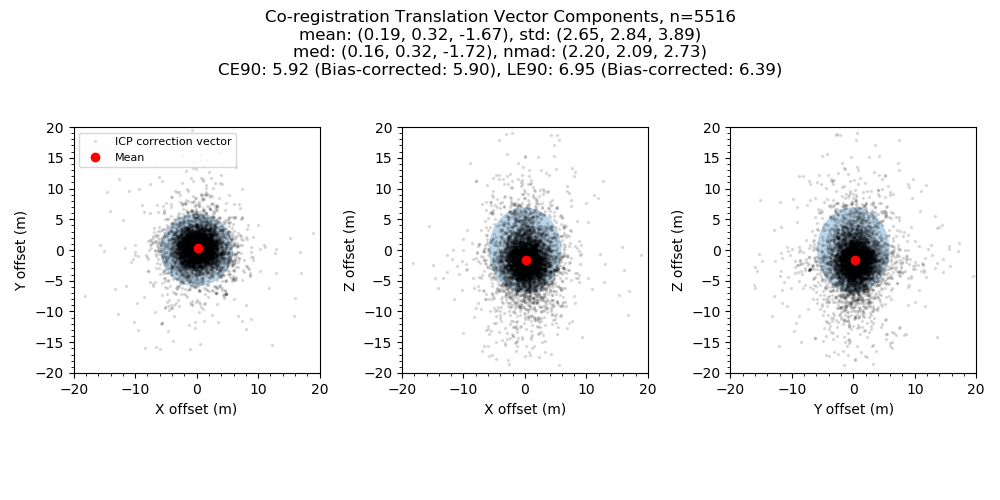

In [264]:
df_filt_sort = df_filt.sort_values(by='dm', ascending=False)
print("Creating plot")
make_plot3d(df_filt_sort, maxdim=(20))
#print("Creating map")
#make_map(df_filt_sort)